In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
from sklearn.preprocessing import MinMaxScaler
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


# Preprocess Data
In the <b>HW3_template</b> folder you will find `TSLA.csv`, `GOOGL.csv` and `DJI.csv` files. Use Pandas (You have used it in HW1) to retrieve the dataset. Use only <b>Open</b> price as your input. (You will train three models for three different stocks, don't mix these data together!)

In [7]:
def load_file(filename):
    file = pd.read_csv(filename)
    file = file.drop(['High','Low','Close','Volume','Date'],axis=1)
    return file
file = load_file('DJI.csv')

## Normalize your data
You could use `MinMaxScaler` in `sklearn.preprocessing` to normalize the data between 0 and 1.

In [8]:
def Normalize(df):
    scaler = MinMaxScaler()
    df['Open'] = scaler.fit_transform(df.Open.values.reshape(-1,1))
    df['Adj Close'] = scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    print(df.head())
    return df
df = Normalize(file)

       Open  Adj Close
0  0.001329   0.001976
1  0.002097   0.001791
2  0.001545   0.001748
3  0.001299   0.001394
4  0.001109   0.001877


# Split training, validation and testing data
<p style="font-size:20px">Since you will impelement a many-to-one Recurrent Neural Network model, every input data will have shape [batch_size, num_seq, input_size] and output data will have shape [batch_size, input_size] 

In [41]:
seq_len = 22
d = 0.5
shape = [2, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    print(type(result[0]))
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 
 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))
    print(np.shape(X_train),'Xshape')
 
    return [X_train, y_train, X_test, y_test]


X_train, y_train, X_test, y_test = load_data(df, seq_len)

<class 'numpy.ndarray'>
(7752, 22, 2) Xshape


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# TesnorFlow Model

In [42]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[2]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model
 
model = build_model2(shape, neurons, d)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 22, 128)           67072     
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 202,817
Trainable params: 202,817
Non-trainable params: 0
_________________________________________________________________


# Training

In [43]:

history=model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 6976 samples, validate on 776 samples
Epoch 1/300
6976/6976 [==============================] - 2s 355us/step - loss: 0.0484 - acc: 1.4335e-04 - val_loss: 0.0310 - val_acc: 0.0000e+00
Epoch 2/300
6976/6976 [==============================] - 1s 116us/step - loss: 0.0074 - acc: 1.4335e-04 - val_loss: 0.0148 - val_acc: 0.0000e+00
Epoch 3/300
6976/6976 [==============================] - 1s 116us/step - loss: 0.0022 - acc: 1.4335e-04 - val_loss: 0.0104 - val_acc: 0.0000e+00
Epoch 4/300
6976/6976 [==============================] - 1s 115us/step - loss: 0.0013 - acc: 1.4335e-04 - val_loss: 0.0142 - val_acc: 0.0000e+00
Epoch 5/300
6976/6976 [==============================] - 1s 109us/step - loss: 0.0011 - acc: 1.4335e-04 - val_loss: 0.0114 - val_acc: 0.0000e+00
Epoch 6/300
6976/6976 [==============================] - 1s 108us/step - loss: 9.2002e-04 - acc: 1.4335e-04 - val_loss: 0.0070 - val_acc: 0.0000e+00
Epoch 7/300
6976/6976 [==============================] - 1s 111us/step - loss: 

Epoch 55/300
6976/6976 [==============================] - 1s 113us/step - loss: 2.9038e-04 - acc: 1.4335e-04 - val_loss: 1.6649e-04 - val_acc: 0.0000e+00
Epoch 56/300
6976/6976 [==============================] - 1s 113us/step - loss: 2.6075e-04 - acc: 1.4335e-04 - val_loss: 1.9625e-04 - val_acc: 0.0000e+00
Epoch 57/300
6976/6976 [==============================] - 1s 115us/step - loss: 2.6279e-04 - acc: 1.4335e-04 - val_loss: 1.6237e-04 - val_acc: 0.0000e+00
Epoch 58/300
6976/6976 [==============================] - 1s 113us/step - loss: 2.4966e-04 - acc: 1.4335e-04 - val_loss: 2.3473e-04 - val_acc: 0.0000e+00
Epoch 59/300
6976/6976 [==============================] - 1s 109us/step - loss: 2.5019e-04 - acc: 1.4335e-04 - val_loss: 2.0318e-04 - val_acc: 0.0000e+00
Epoch 60/300
6976/6976 [==============================] - 1s 110us/step - loss: 2.4311e-04 - acc: 1.4335e-04 - val_loss: 3.3125e-04 - val_acc: 0.0000e+00
Epoch 61/300
6976/6976 [==============================] - 1s 111us/step - lo

Epoch 109/300
6976/6976 [==============================] - 1s 114us/step - loss: 1.2699e-04 - acc: 1.4335e-04 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 110/300
6976/6976 [==============================] - 1s 113us/step - loss: 1.2832e-04 - acc: 1.4335e-04 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 111/300
6976/6976 [==============================] - 1s 110us/step - loss: 1.2698e-04 - acc: 1.4335e-04 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 112/300
6976/6976 [==============================] - 1s 112us/step - loss: 1.1976e-04 - acc: 1.4335e-04 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 113/300
6976/6976 [==============================] - 1s 114us/step - loss: 1.2139e-04 - acc: 1.4335e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 114/300
6976/6976 [==============================] - 1s 111us/step - loss: 1.1965e-04 - acc: 1.4335e-04 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 115/300
6976/6976 [==============================] - 1s 111us/step - loss: 1.2154e-04 - 

6976/6976 [==============================] - 1s 113us/step - loss: 1.0063e-04 - acc: 1.4335e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 164/300
6976/6976 [==============================] - 1s 111us/step - loss: 1.1253e-04 - acc: 1.4335e-04 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 165/300
6976/6976 [==============================] - 1s 112us/step - loss: 1.0354e-04 - acc: 1.4335e-04 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 166/300
6976/6976 [==============================] - 1s 111us/step - loss: 1.0085e-04 - acc: 1.4335e-04 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 167/300
6976/6976 [==============================] - 1s 112us/step - loss: 1.0870e-04 - acc: 1.4335e-04 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 168/300
6976/6976 [==============================] - 1s 113us/step - loss: 1.0737e-04 - acc: 1.4335e-04 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 169/300
6976/6976 [==============================] - 1s 114us/step - loss: 1.0832e-04 - acc: 1.4335e-0

6976/6976 [==============================] - 1s 112us/step - loss: 1.0133e-04 - acc: 1.4335e-04 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 218/300
6976/6976 [==============================] - 1s 110us/step - loss: 1.0626e-04 - acc: 1.4335e-04 - val_loss: 8.8598e-04 - val_acc: 0.0000e+00
Epoch 219/300
6976/6976 [==============================] - 1s 111us/step - loss: 9.4332e-05 - acc: 1.4335e-04 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 220/300
6976/6976 [==============================] - 1s 114us/step - loss: 9.7885e-05 - acc: 1.4335e-04 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 221/300
6976/6976 [==============================] - 1s 110us/step - loss: 9.4283e-05 - acc: 1.4335e-04 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 222/300
6976/6976 [==============================] - 1s 110us/step - loss: 9.6880e-05 - acc: 1.4335e-04 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 223/300
6976/6976 [==============================] - 1s 112us/step - loss: 1.0645e-04 - acc: 1.433

6976/6976 [==============================] - 1s 116us/step - loss: 9.7099e-05 - acc: 1.4335e-04 - val_loss: 3.8461e-04 - val_acc: 0.0000e+00
Epoch 271/300
6976/6976 [==============================] - 1s 114us/step - loss: 9.9674e-05 - acc: 1.4335e-04 - val_loss: 5.9155e-04 - val_acc: 0.0000e+00
Epoch 272/300
6976/6976 [==============================] - 1s 111us/step - loss: 9.2925e-05 - acc: 1.4335e-04 - val_loss: 9.4492e-04 - val_acc: 0.0000e+00
Epoch 273/300
6976/6976 [==============================] - 1s 113us/step - loss: 8.8171e-05 - acc: 1.4335e-04 - val_loss: 8.4720e-04 - val_acc: 0.0000e+00
Epoch 274/300
6976/6976 [==============================] - 1s 110us/step - loss: 8.6416e-05 - acc: 1.4335e-04 - val_loss: 5.6484e-04 - val_acc: 0.0000e+00
Epoch 275/300
6976/6976 [==============================] - 1s 116us/step - loss: 8.6716e-05 - acc: 1.4335e-04 - val_loss: 5.9457e-04 - val_acc: 0.0000e+00
Epoch 276/300
6976/6976 [==============================] - 1s 115us/step - loss: 9.3

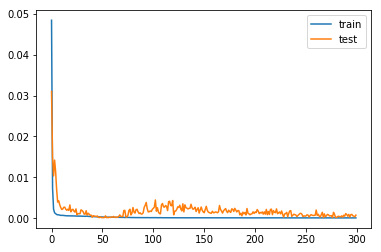

In [44]:

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Testing

In [49]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
 
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]
 
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00011 MSE (0.01 RMSE)
Test Score: 0.01323 MSE (0.12 RMSE)


(0.00010800967904158447, 0.013233818150580829)

In [50]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]
 
    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u
 
        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p
p = percentage_difference(model, X_test, y_test)

In [51]:
def denormalize(stock_name, normalized_value):
    df = load_file('DJI.csv')
    
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

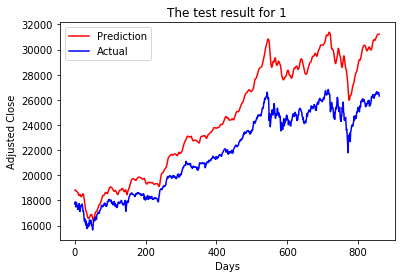

In [52]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt.plot(newp, color='red', label='Prediction')
    plt.plot(newy_test,color='blue', label='Actual')
    plt.legend(loc='best')
    plt.title('The test result for {}'.format(stock_name))
    plt.xlabel('Days')
    plt.ylabel('Adjusted Close')
    plt.show()
    
plot_result('1', p, y_test)